In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import time
import os

# proxyの設定．
# keras.datasetsでは，datasetを直接ダウンロードするので，学内マシンからは通常必要．
os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"      # "0":GPU0, "1":GPU1, "0,1":GPUを2つとも使用

import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# ResNet50 による 1000種類分類
import torchvision.models as models

from PIL import Image
import torchvision.transforms as transforms
import glob
from sklearn.svm import LinearSVC
import time

In [2]:
resnet50 = models.resnet50(pretrained=True,progress=True)
resnet50 = resnet50.to("cuda:0")
softmax=nn.Softmax(dim=1)

In [3]:
img = Image.open('animal/cat/458008.jpg')
img = Image.open('animal/dog/415002.jpg')
img = Image.open('animal/horse/197006.jpg')
img = Image.open('animal/lion/105000.jpg')
img = Image.open('animal/tiger/108000.jpg')

In [4]:
# 認識結果の top-5 の結果の表示
SYNSET_FILE='synset_words.txt'  # ImageNet1000 種類のカテゴリ名が書かれたファイル．
synset=open(SYNSET_FILE).read().split('\n')

In [52]:
image_size = (256, 256) 
occluder = (64,64)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
image_transform = transforms.Compose([transforms.Resize(image_size),transforms.ToTensor(),normalize])
img = Image.open('animal/cat/458008.jpg')
img = image_transform(img)
img = img.unsqueeze(0)
img = img.to("cuda:0")
img.requires_grad = True

In [53]:
resnet50.eval() 
with torch.no_grad(): 
    out=softmax(resnet50(img)).cpu().numpy()[0]
top5   =np.sort(out)[:-6:-1]   
top5idx=np.argsort(out)[:-6:-1] 
for i in range(5):
    print("[%d] %.8f %s" % (i+1,top5[i],synset[top5idx[i]]))

[1] 0.98997796 n02123597 Siamese cat, Siamese
[2] 0.00551509 n02127052 lynx, catamount
[3] 0.00193987 n02124075 Egyptian cat
[4] 0.00052262 n02085620 Chihuahua
[5] 0.00037846 n02125311 cougar, puma, catamount, mountain lion, painter, panther, Felis concolor


In [54]:
dzdy =torch.zeros([1,1000]).to("cuda:0")
print(top5idx[0])
dzdy[0,top5idx[0]]=1

resnet50(img).backward(dzdy)
print(img.grad[0].shape)
heatmap=abs(img.grad[0].cpu().numpy()) # 絶対値を取ります．
heatmap= heatmap.max(axis = 0)    # RGB のうちの最大値を取ります．
maxv=heatmap.max()     # 最大値を求めます．  
heatmap=heatmap/maxv         # 最大値で割って，値が0～1の間になるようにします．

#plt.imshow(heatmap,cmap='hot', interpolation='nearest')

284
torch.Size([3, 256, 256])


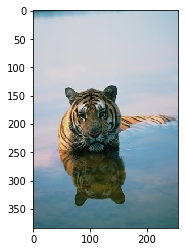

In [40]:
plt.imshow(Image.open('animal/tiger/108000.jpg'))

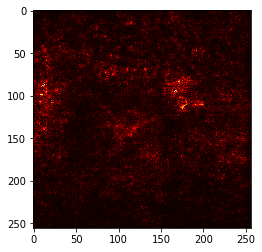

In [41]:
plt.imshow(heatmap,cmap='hot', interpolation='nearest')

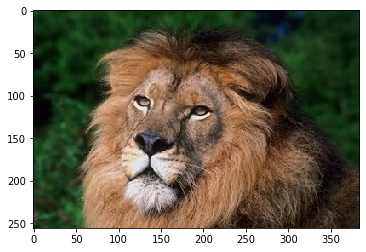

In [35]:
plt.imshow(Image.open('animal/lion/105000.jpg'))

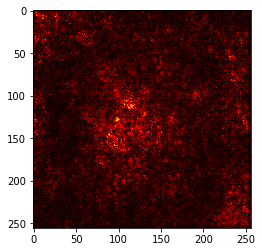

In [36]:
plt.imshow(heatmap,cmap='hot', interpolation='nearest')

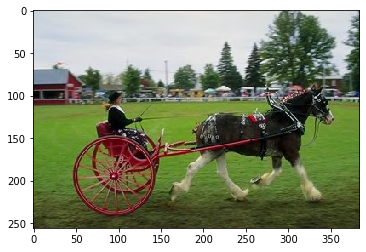

In [45]:
plt.imshow(Image.open('animal/horse/197006.jpg'))

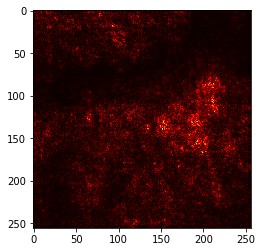

In [46]:
plt.imshow(heatmap,cmap='hot')

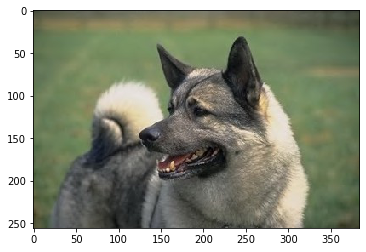

In [50]:
plt.imshow(Image.open('animal/dog/415002.jpg'))

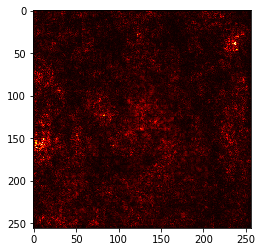

In [51]:
plt.imshow(heatmap,cmap='hot', interpolation='nearest')

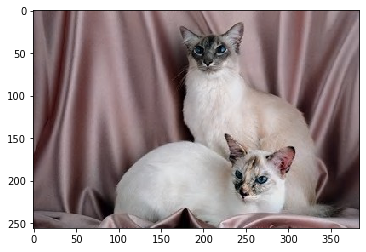

In [55]:
plt.imshow(Image.open('animal/cat/458008.jpg'))

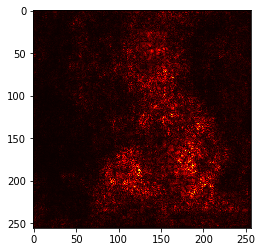

In [56]:
plt.imshow(heatmap,cmap='hot', interpolation='nearest')

B4-3bより、取るピクセルの単位が少ないので、きめ細やかなヒートマップになっている。
猫の画像なんかは明確に出ている。大体前問と同じようなところに出ているように思う。

### smooth grad
from https://github.com/hs2k/pytorch-smoothgrad/blob/master/saliency.py

In [57]:
image_size = (256, 256) 
occluder = (64,64)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
image_transform = transforms.Compose([transforms.Resize(image_size),transforms.ToTensor(),normalize])
img = Image.open('animal/cat/458008.jpg')
img = image_transform(img)
img = img.unsqueeze(0)
img = img.to("cuda:0")
img.requires_grad = True

In [58]:
resnet50.eval() 
with torch.no_grad(): 
    out=softmax(resnet50(img)).cpu().numpy()[0]
top5   =np.sort(out)[:-6:-1]   
top5idx=np.argsort(out)[:-6:-1] 
for i in range(1):
    print("[%d] %.8f %s" % (i+1,top5[i],synset[top5idx[i]]))

[1] 0.98997796 n02123597 Siamese cat, Siamese


284
torch.Size([25, 3, 256, 256])


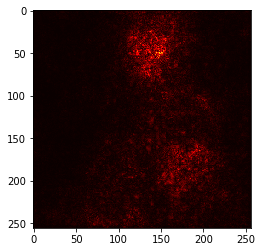

In [68]:
from torch.autograd import Variable
sample_size = 25

dzdy =torch.zeros([sample_size,1000]).to("cuda:0")
print(top5idx[0])
dzdy[0,top5idx[0]]=1

#noise
img = img.expand(sample_size,*img.shape[1:])
img = img + (torch.randn(*img.shape).to("cuda:0")*0.15)
img = Variable(img, requires_grad=True)

resnet50(img).backward(dzdy)
print(img.grad.shape)
heatmap = torch.mean(img.grad,axis=0)
heatmap=abs(heatmap.cpu().numpy()) # 絶対値を取ります．
heatmap= heatmap.max(axis = 0)    # RGB のうちの最大値を取ります．
maxv=heatmap.max()     # 最大値を求めます．  
heatmap=heatmap/maxv         # 最大値で割って，値が0～1の間になるようにします．

#plt.imshow(heatmap,cmap='hot', interpolation='nearest')

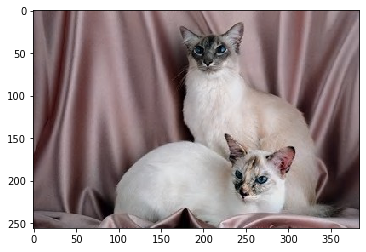

In [55]:
plt.imshow(Image.open('animal/cat/458008.jpg'))

ある程度固まった場所にヒートマップが出現している。また、対象外の場所についてはきれいに黒くなっている。

### Guided BP
from https://github.com/hs2k/pytorch-smoothgrad/blob/master/saliency.py  <br>
https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/master/src/guided_backprop.py<br>

In [5]:
guided_model = models.vgg16(pretrained=True)

relu_forward_output=[]
def relu_forward_hook(module, ten_in, ten_out):
    relu_forward_output.append(ten_out)
def relu_backward_hook(module, grad_in, grad_out):
    forward_output = relu_forward_output[-1]
    forward_output[forward_output>0]=1
    modified_grad_out = torch.clamp(grad_in[0], min=0.0)*forward_output
    
    del relu_forward_output[-1]
    return (modified_grad_out,)

for pos, module in guided_model.features._modules.items():
    if isinstance(module, nn.ReLU):
        module.register_backward_hook(relu_backward_hook)
        module.register_forward_hook(relu_forward_hook)
#モデルの各reluに順に適用

guided_model = guided_model.to("cuda:0")

In [6]:
#change 256->224
image_size = (224, 224) 
occluder = (64,64)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
image_transform = transforms.Compose([transforms.Resize(image_size),transforms.ToTensor(),normalize])
img = Image.open('animal/cat/458008.jpg')
img = image_transform(img)
img = img.unsqueeze(0)
img = img.to("cuda:0")
img.requires_grad = True

In [7]:
guided_model.eval() 
with torch.no_grad(): 
    out=softmax(guided_model(img)).cpu().numpy()[0]
top5   =np.sort(out)[:-6:-1]   
top5idx=np.argsort(out)[:-6:-1] 
for i in range(1):
    print("[%d] %.8f %s" % (i+1,top5[i],synset[top5idx[i]]))

[1] 0.85490131 n02123597 Siamese cat, Siamese


284
torch.Size([3, 224, 224])


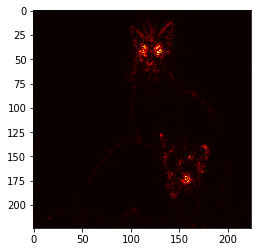

In [10]:
dzdy =torch.zeros([1,1000]).to("cuda:0")
print(top5idx[0])
dzdy[0,top5idx[0]]=1

guided_model(img).backward(dzdy)

print(img.grad[0].shape)
heatmap=abs(img.grad[0].cpu().numpy()) # 絶対値を取ります．
heatmap= heatmap.max(axis = 0)    # RGB のうちの最大値を取ります．
maxv=heatmap.max()     # 最大値を求めます．  
heatmap=heatmap/maxv         # 最大値で割って，値が0～1の間になるようにします．

plt.imshow(heatmap,cmap='hot', interpolation='nearest')

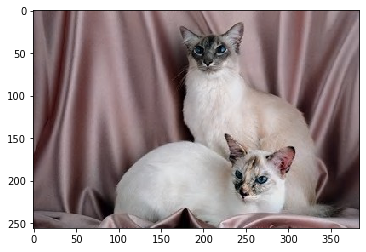

In [55]:
plt.imshow(Image.open('animal/cat/458008.jpg'))

In [ ]:
目と耳に注目があつまり、輪郭がヒートマップに明確に出ている。今回のものは、正の傾きのみ取り出していたが、負の傾きでも同じようなことができるように思う。

参考<br>
https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html<br>
https://github.com/hs2k/pytorch-smoothgrad<br>